In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.colors import Normalize
from IPython.display import HTML

WINDOW = 6

In [2]:
watermask = torch.tensor(plt.imread('mask.png')[:-1,:,0]<0.5,dtype=torch.float).to('cuda')
avg = torch.unsqueeze((torch.tensor(np.load('avg.npy')[:-1],dtype=torch.float) + torch.zeros((7,824,200))),0).to('cuda')

In [3]:
data = np.concatenate([
    np.expand_dims(np.load('radars.npy'), 1), 
    np.load('gfs.npy'),
    np.load('glorys.npy')
], 1)
X, y = [], []
for i in range(334, 425-WINDOW):
    X.append(data[i : i+WINDOW, :, :-1])
    y.append(data[i+3 : i+3+WINDOW, :, :-1])
X = torch.tensor(np.stack(X),dtype=torch.float)
y = torch.tensor(np.stack(y),dtype=torch.float)
del data
print(X.shape, y.shape)

torch.Size([85, 6, 7, 824, 200]) torch.Size([85, 6, 7, 824, 200])


In [37]:
class EUNet(nn.Module):
    def __init__(self, hidden=64, steps=1, dropout=0, channels=7, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.steps = steps
        ec = hidden
        nc = hidden*2
        dc = hidden
        self.encoder = nn.Sequential(
            nn.AvgPool2d(2, 2),
            nn.Conv2d(channels, ec, 3, padding=1),
            nn.BatchNorm2d(ec),
            nn.ReLU(True),
            nn.Dropout2d(dropout),
            nn.Conv2d(ec, ec, 3, padding=1),
            nn.BatchNorm2d(ec),
            nn.ReLU(True),
        )
        self.neck = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(ec, nc, 3, padding=1),
            nn.BatchNorm2d(nc),
            nn.ReLU(True),
            nn.Dropout2d(dropout),
            nn.Conv2d(nc, nc, 3, padding=1),
            nn.BatchNorm2d(nc),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(ec+nc, dc, 3, padding=1),
            nn.BatchNorm2d(dc),
            nn.ReLU(True),
            nn.Dropout2d(dropout),
            nn.Conv2d(dc, dc, 3, padding=1),
            nn.BatchNorm2d(dc),
            nn.ReLU(True),
            nn.Conv2d(dc, channels, 1),
            nn.Upsample(scale_factor=2, mode='bicubic')
        )

    def forward(self, inputs):
        x = inputs
        for _ in range(self.steps):
            m = self.encoder(x)
            m = torch.cat((m, self.neck(m)), dim=1)
            # x = x + self.decoder(mf)
            x = self.decoder(m)
        return x
    
def ffill(inputs, state): # TODO: maybe add more weight
    '''Fullfill missed regions in inputs with state'''
    mask = inputs > 0.3
    out = inputs * mask + state * ~mask
    return out


class TSWrapper(nn.Module):
    def __init__(self, cell, avg_state, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.cell = cell
        self.avg_state = avg_state

    def forward(self, inputs):
        '''inputs shape: batch, window, channel, height, width
        Forcasts up to 3 days in the future.'''
        x = self.avg_state
        outputs = []
        # warming model
        for i in range(inputs.shape[1]):
            x = ffill(inputs[:,i], x)
            x = self.cell(x)
            outputs.append(x[:,0])
        # forecast
        for i in range(2):
            x = self.cell(x)
            outputs.append(x[:,0])
        return torch.stack(outputs[2:]).transpose(0,1)

In [81]:
cell = EUNet(64, steps=1, dropout=1e-2, channels=7)
model = TSWrapper(cell, avg).to('cuda')
opt = torch.optim.Adam(model.parameters(), 1e-4, (0.9, 0.999))
loader = DataLoader(TensorDataset(X, y), 4, True)
criteria = nn.MSELoss()
losses = []

In [96]:
model.train()
t = trange(10)
for _ in t:
    tlosses = []
    for X_tr, y_tr in loader:
        X_tr, y_tr = X_tr.to('cuda'), y_tr.to('cuda')
        y_pred = model(X_tr)
        loss = criteria(y_pred*watermask*(y_tr[:,:,0]>0.3), y_tr[:,:,0]*watermask) #TODO: better pred mask
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss = loss.detach().cpu().numpy()
        tlosses.append(loss)
    loss = np.mean(tlosses)
    t.set_postfix(loss=loss)
    losses.append(loss)

100%|██████████| 10/10 [01:34<00:00,  9.45s/it, loss=0.00355]


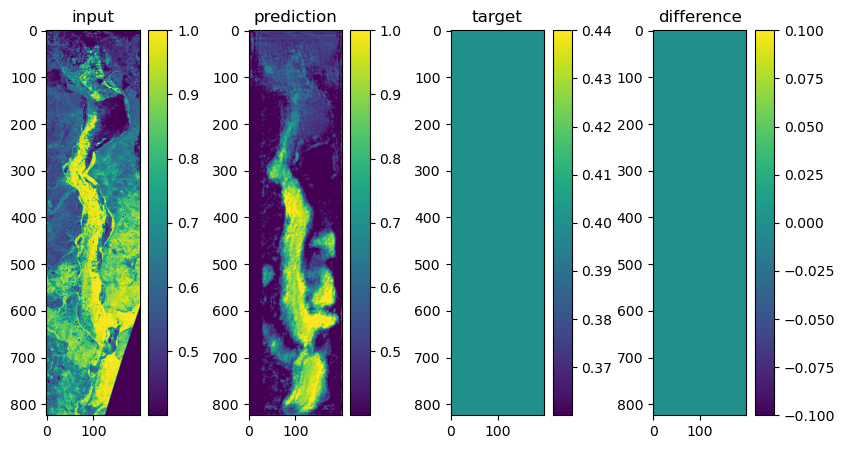

In [97]:
inp = X_tr[:1,:1]
out = (model(inp)).detach().cpu().numpy()[0,0]
tar = y_tr[0,0,0].cpu().numpy()

plt.figure(figsize=(10,5))

plt.subplot(141)
im = np.clip(inp.cpu().numpy()[0,0,0], 0.4, 1)
plt.imshow(im)
plt.title('input')
plt.colorbar()

plt.subplot(142)
im = np.clip(out, 0.4, 1)
plt.imshow(im)
plt.title('prediction')
plt.colorbar()

plt.subplot(143)
im = np.clip(tar, 0.4, 1)
plt.imshow(im)
plt.title('target')
plt.colorbar()

plt.subplot(144)
im = (tar-out)*(tar>0.3)*watermask.cpu().numpy()
plt.imshow(im)
plt.title('difference')
plt.colorbar()

plt.show()

In [22]:
# torch.save(model.state_dict(), 'checkpoint')

In [15]:
# cell = EUNet(64, dropout=0, channels=7)
# model = TSWrapper(cell, avg).to('cuda')
# model.load_state_dict(torch.load('checkpoint'))
# None

In [98]:
data = np.concatenate([
    np.expand_dims(np.load('radars.npy'), 1), 
    np.load('gfs.npy'),
    np.load('glorys.npy')
], 1)[334:425]

In [99]:
prediction = []
x = model.avg_state
model.eval()
with torch.no_grad():
    for i in trange(425-334):
        inp = torch.tensor(data[i:i+1:,:,:-1],dtype=torch.float).to('cuda')
        x = ffill(inp, x)
        x = model.cell(x)
        prediction.append(x.detach().cpu().numpy())
prediction = np.vstack(prediction)
prediction.shape

100%|██████████| 91/91 [00:00<00:00, 95.94it/s] 


(91, 7, 824, 200)

In [100]:
print(prediction.min(), prediction.max())

-1.1406763 1.5220649


In [101]:
chan = 0
mask = np.expand_dims(watermask.cpu().numpy(),0)
target = np.clip(data[1:,chan,:-1]*mask,0,1)
video = np.clip(prediction[:-1,chan]*mask,0,1)

In [102]:
norm = Normalize(0, 1)

fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,3)
im0 = ax[0].imshow(video[0,:,:], norm=norm)
im1 = ax[1].imshow(target[0,:,:], norm=norm)
im2 = ax[2].imshow(target[0,:,:]-video[0,:,:], norm=norm)

plt.close() # this is required to not display the generated image

def init():
    im0.set_data(video[0,:,:])
    im1.set_data(target[0,:,:])
    im2.set_data(target[0,:,:]-video[0,:,:])

def animate(i):
    im0.set_data(video[i,:,:])
    im1.set_data(target[i,:,:])
    im2.set_data(target[i,:,:]-video[i,:,:])
    return [im0, im1, im2]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=200)
HTML(anim.to_html5_video())

In [64]:
radars = np.reshape(np.load('radars.npy'),(-1,))

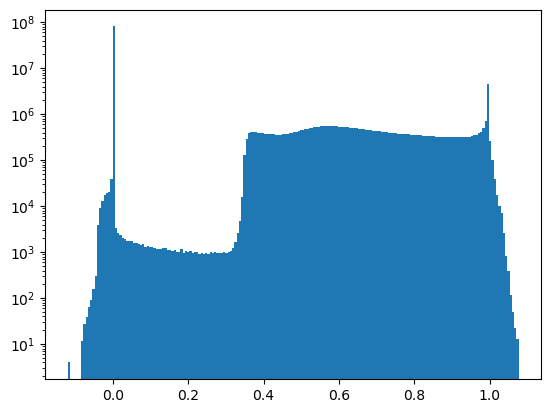

In [77]:
plt.hist(radars[:], 200, log=True)
plt.show()